In [1]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import plotly.express as px

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
data = pd.read_csv("data_for_models.csv")

In [3]:
data.fillna(0, inplace=True)

In [4]:
data.columns.to_list()

['Unnamed: 0',
 'striker',
 'totalrunsscored',
 'Total_batting_average',
 'batting_strike_rate',
 'totalballsfaced',
 'totalwickets',
 'economyrate',
 'oversbowled_clean']

                       totalrunsscored  Total_batting_average  \
totalrunsscored               1.000000               0.703139   
Total_batting_average         0.703139               1.000000   
batting_strike_rate           0.416145               0.621497   
totalballsfaced               0.994913               0.690230   
totalwickets                 -0.156821              -0.199768   
economyrate                  -0.266214              -0.322166   
oversbowled_clean            -0.142819              -0.190167   

                       batting_strike_rate  totalballsfaced  totalwickets  \
totalrunsscored                   0.416145         0.994913     -0.156821   
Total_batting_average             0.621497         0.690230     -0.199768   
batting_strike_rate               1.000000         0.389275     -0.150512   
totalballsfaced                   0.389275         1.000000     -0.150766   
totalwickets                     -0.150512        -0.150766      1.000000   
economyrate      

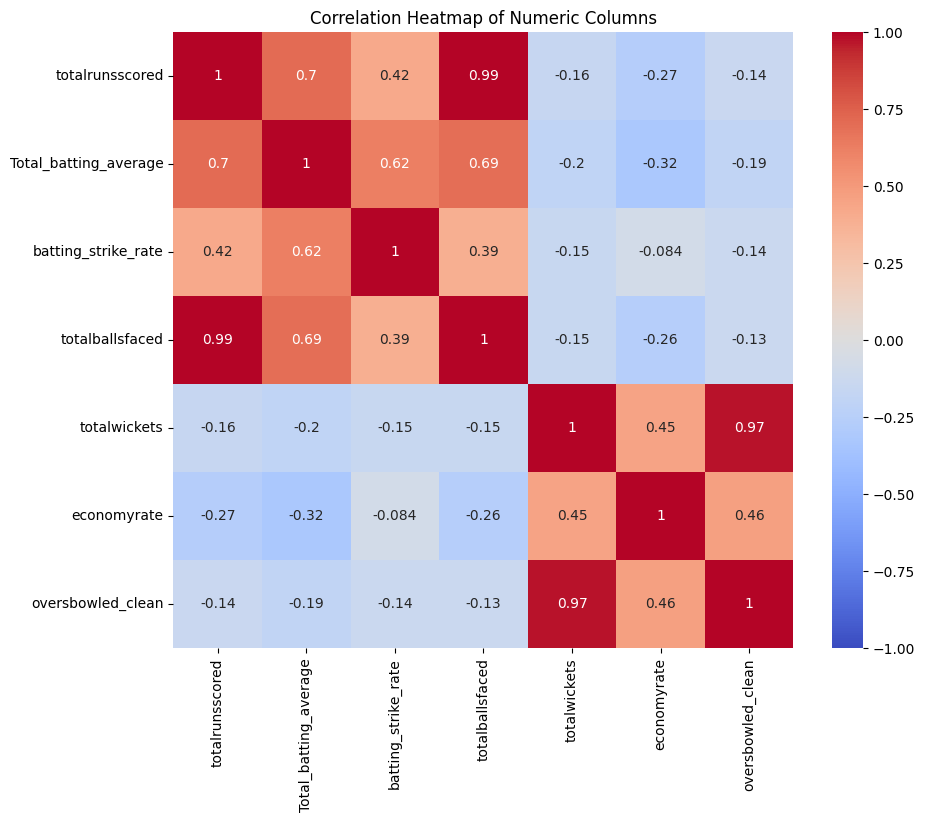

In [5]:
cr_data = data[['totalrunsscored',
 'Total_batting_average',
 'batting_strike_rate',
 'totalballsfaced',
 'totalwickets',
 'economyrate',
 'oversbowled_clean']]
cf = cr_data.corr()

# Print correlation matrix
print(cf)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cf, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

In [6]:
# Now see the distribution of runs scored in 2024 and 2023

# Create the histogram for runs in 2024
fig1 = px.histogram(data, x='totalrunsscored', 
                   title='runs in 2021 to 2024 distribution in Histogram', 
                   labels={'runsin2024': 'Runs scored', 'count': 'Frequency'})

# Store the result in a tuple
result1 = (fig1, 'Runs Histogram', 'Distribution of runs')




# To display the plot (if you're in a Jupyter notebook or similar environment)
fig1.show()

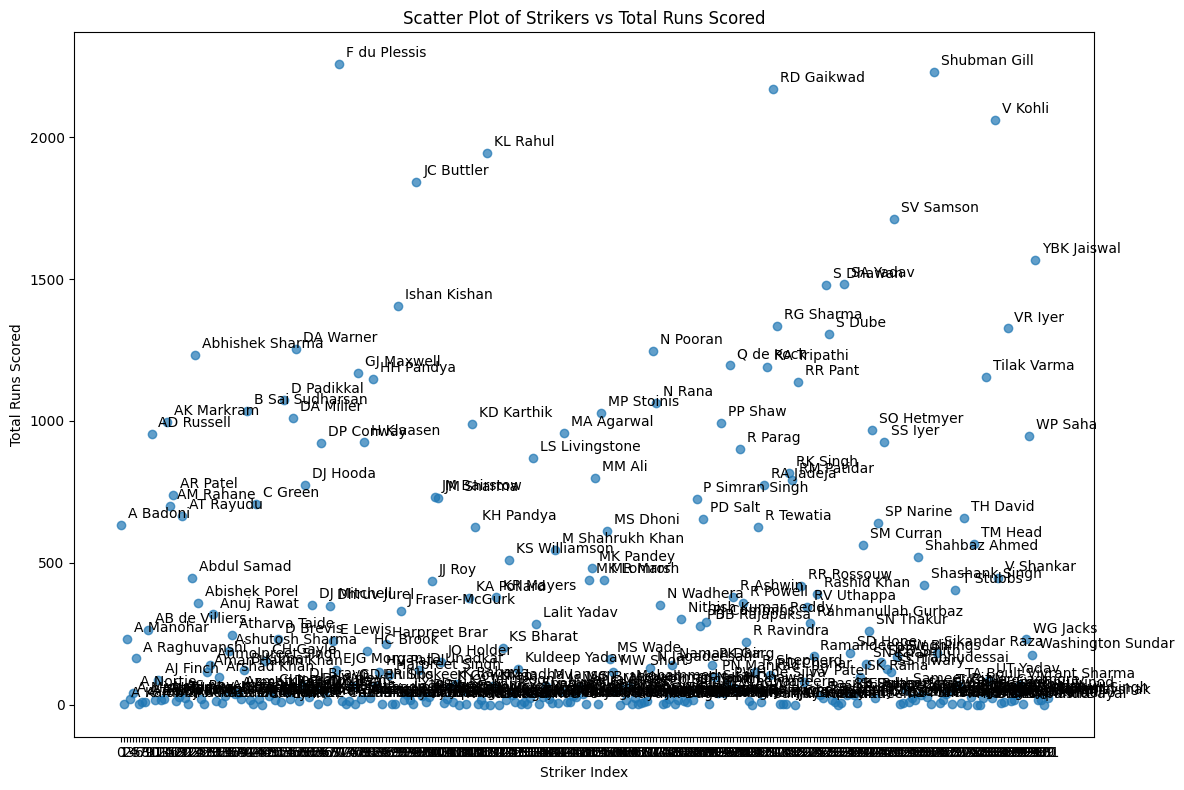

In [7]:

# Create the scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(data.index, data['totalrunsscored'], alpha=0.7)
plt.xlabel('Striker Index')  # Use index for x-axis
plt.ylabel('Total Runs Scored')
plt.title('Scatter Plot of Strikers vs Total Runs Scored')

# Add labels for each point using the striker names
for i, txt in enumerate(data['striker']):
    plt.annotate(txt, (data.index[i], data['totalrunsscored'][i]), 
                 xytext=(5, 5), textcoords='offset points')

plt.xticks(data.index)  # Set x-ticks to be the index
plt.tight_layout()
plt.show()

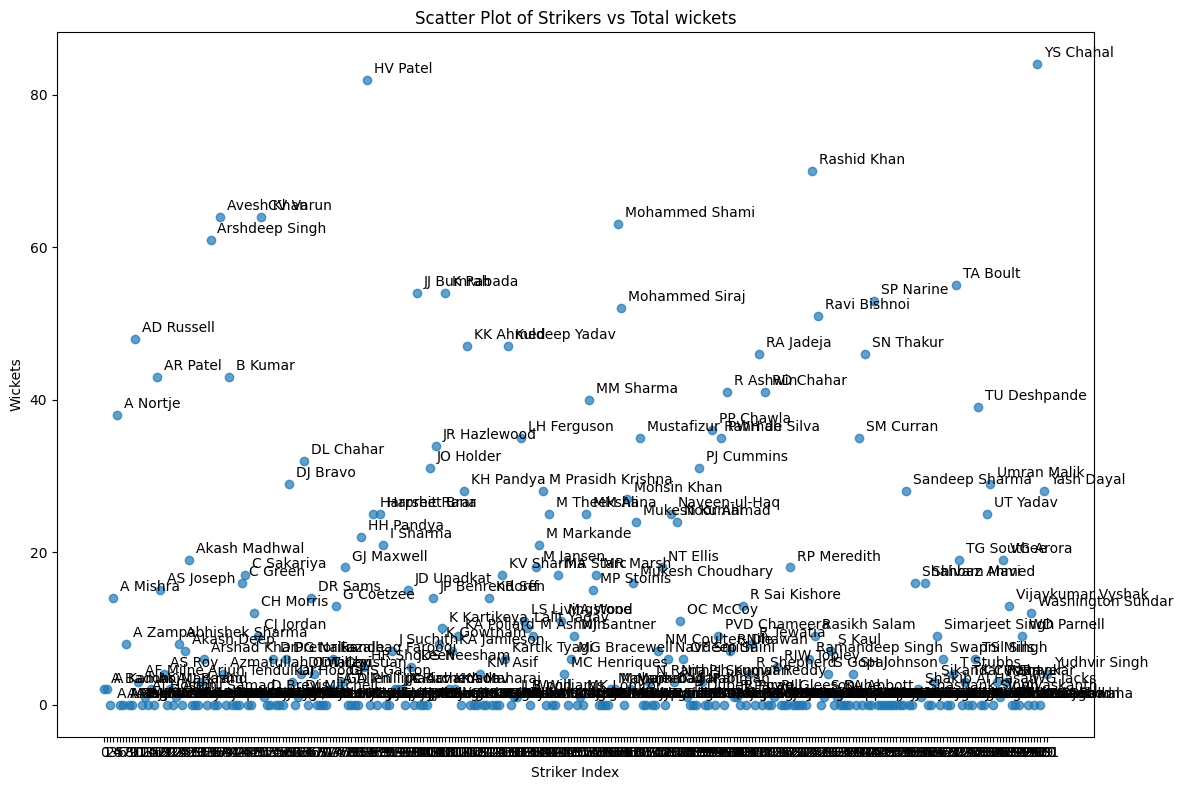

In [8]:
# Create the scatter plot
plt.figure(figsize=(12, 8))

# players with economy 10 and less and more than 5 wickets
data['economyrate'] = pd.to_numeric(data['economyrate'], errors='coerce')

# Now apply the filter
# modified_data = data[
#     (data['economyrate'].notna()) &  # Exclude NaN values
#     (data['economyrate'] <= 12.00) & 
#     (data['totalwickets'] >= 15)
# ]

modified_data = data

plt.scatter(modified_data.index, modified_data['totalwickets'], alpha=0.7)
plt.xlabel('Striker Index')  # Use index for x-axis
plt.ylabel('Wickets')
plt.title('Scatter Plot of Strikers vs Total wickets')

# Add labels for each point using the striker names
for i, txt in enumerate(modified_data['striker']):
    plt.annotate(txt, (modified_data.index[i], data['totalwickets'][i]), 
                 xytext=(5, 5), textcoords='offset points')

plt.xticks(data.index)  # Set x-ticks to be the index
plt.tight_layout()
plt.show()

Now ranking each payers based on the rule based ranking system on the scale of 100

In [9]:
ranking_data = data.copy()

# Normalize metrics
metrics_to_normalize = ['totalrunsscored', 'Total_batting_average', 'batting_strike_rate', 'totalwickets']
for metric in metrics_to_normalize:
    ranking_data[f'{metric}_norm'] = (ranking_data[metric] - ranking_data[metric].min()) / (ranking_data[metric].max() - ranking_data[metric].min())

# Normalize economy rate (lower is better)
ranking_data['economyrate_norm'] = 1 - (ranking_data['economyrate'] - ranking_data['economyrate'].min()) / (ranking_data['economyrate'].max() - ranking_data['economyrate'].min())

# Assign weights
batting_weights = {
    'totalrunsscored_norm': 0.4,
    'Total_batting_average_norm': 0.3,
    'batting_strike_rate_norm': 0.3
}

bowling_weights = {
    'totalwickets_norm': 0.6,
    'economyrate_norm': 0.4
}

# Determine player type
def determine_player_type(row):
    if row['totalrunsscored'] >= 100 and row['totalwickets'] <= 2 and row['totalballsfaced'] >= 40:
        return 'Batsman'
    elif row['totalwickets'] > 5 and row['totalrunsscored'] <= 100:
        return 'Bowler'
    elif row['totalwickets'] >= 3 and row['totalrunsscored'] >= 100:
        return 'All-rounder'
    return 'Other Players'

ranking_data['Player_type'] = ranking_data.apply(determine_player_type, axis=1)

# Calculate scores based on player type
def calculate_score(row):
    if row['Player_type'] == 'Batsman':
        return sum(row[metric] * weight for metric, weight in batting_weights.items()) * 100
    elif row['Player_type'] == 'Bowler':
        return sum(row[metric] * weight for metric, weight in bowling_weights.items()) * 100
    elif row['Player_type'] == 'All-rounder':
        batting_score = sum(row[metric] * weight for metric, weight in batting_weights.items()) * 100
        bowling_score = sum(row[metric] * weight for metric, weight in bowling_weights.items()) * 100
        return (batting_score + bowling_score) / 2
    return 0

ranking_data['Overall_score'] = ranking_data.apply(calculate_score, axis=1)

# Rank players within each category
ranking_data['Rank'] = ranking_data.groupby('Player_type')['Overall_score'].rank(ascending=False, method='min')

# Sort the dataframe by Player_type and Rank
ranked_data = ranking_data.sort_values(['Player_type', 'Rank'])

# Display the ranked players
for player_type in ranked_data['Player_type'].unique():
    print(f"\n## {player_type}")
    players = ranked_data[ranked_data['Player_type'] == player_type]
    for _, player in players.iterrows():
        print(f"{player['Rank']:.0f}. {player['striker']} (Score: {player['Overall_score']:.2f})")


## All-rounder
1. Rashid Khan (Score: 54.49)
2. AD Russell (Score: 51.74)
3. RA Jadeja (Score: 51.51)
4. SP Narine (Score: 51.03)
5. HV Patel (Score: 50.57)
6. AR Patel (Score: 48.79)
7. GJ Maxwell (Score: 44.31)
8. HH Pandya (Score: 43.26)
9. R Ashwin (Score: 42.11)
10. MM Ali (Score: 42.06)
11. C Green (Score: 41.54)
12. SN Thakur (Score: 41.53)
13. SM Curran (Score: 41.37)
14. Abhishek Sharma (Score: 40.63)
15. Kuldeep Yadav (Score: 40.56)
16. MP Stoinis (Score: 40.25)
17. KH Pandya (Score: 39.32)
18. PJ Cummins (Score: 39.18)
19. LS Livingstone (Score: 38.86)
20. VR Iyer (Score: 38.28)
21. B Kumar (Score: 37.00)
22. RD Chahar (Score: 36.24)
23. N Rana (Score: 36.20)
24. T Stubbs (Score: 36.01)
25. Harpreet Brar (Score: 34.72)
26. MR Marsh (Score: 34.28)
27. JO Holder (Score: 33.75)
28. Shahbaz Ahmed (Score: 32.73)
29. R Tewatia (Score: 32.62)
30. DJ Hooda (Score: 31.43)
31. KA Pollard (Score: 31.00)
32. Ramandeep Singh (Score: 30.64)
33. Nithish Kumar Reddy (Score: 29.50)
34. V Sh

In [10]:
ranking_data.head()

,Unnamed: 0,striker,totalrunsscored,Total_batting_average,batting_strike_rate,totalballsfaced,totalwickets,economyrate,oversbowled_clean,totalrunsscored_norm,Total_batting_average_norm,batting_strike_rate_norm,totalwickets_norm,economyrate_norm,Player_type,Overall_score,Rank
0,0,A Badoni,634.0,24.384615,125.54,505.0,2.0,9.27,4.1,0.280904,0.353400,0.418467,0.023810,0.652418,Batsman,34.392161,49.0
1,1,A Kamboj,2.0,0.000000,100.00,2.0,2.0,11.07,11.2,0.000886,0.000000,0.333333,0.023810,0.584927,Other Players,0.000000,1.0
2,2,A Manohar,231.0,16.500000,127.62,181.0,0.0,0.00,0.0,0.102348,0.239130,0.425400,0.000000,1.000000,Batsman,24.029843,79.0
3,3,A Mishra,19.0,19.000000,63.33,30.0,14.0,7.98,32.1,0.008418,0.275362,0.211100,0.166667,0.700787,Bowler,38.031496,42.0
4,4,A Nortje,42.0,8.400000,93.33,45.0,38.0,9.57,120.1,0.018609,0.121739,0.311100,0.452381,0.641170,Bowler,52.789651,15.0


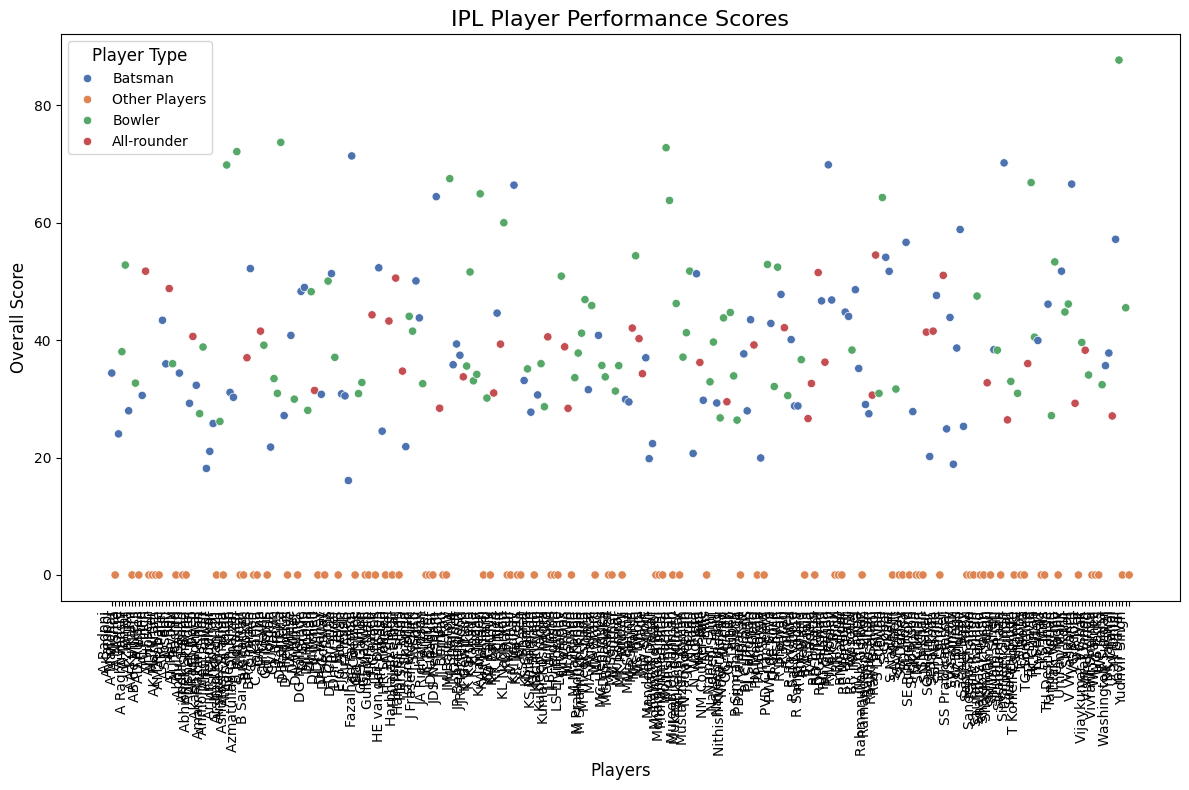

In [11]:
# Create the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=ranking_data, x='striker', y='Overall_score', hue='Player_type', palette='deep')

# Customize the plot
plt.title('IPL Player Performance Scores', fontsize=16)
plt.xlabel('Players', fontsize=12)
plt.ylabel('Overall Score', fontsize=12)
plt.xticks(rotation=90, ha='right')
plt.legend(title='Player Type', title_fontsize='12', fontsize='10')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

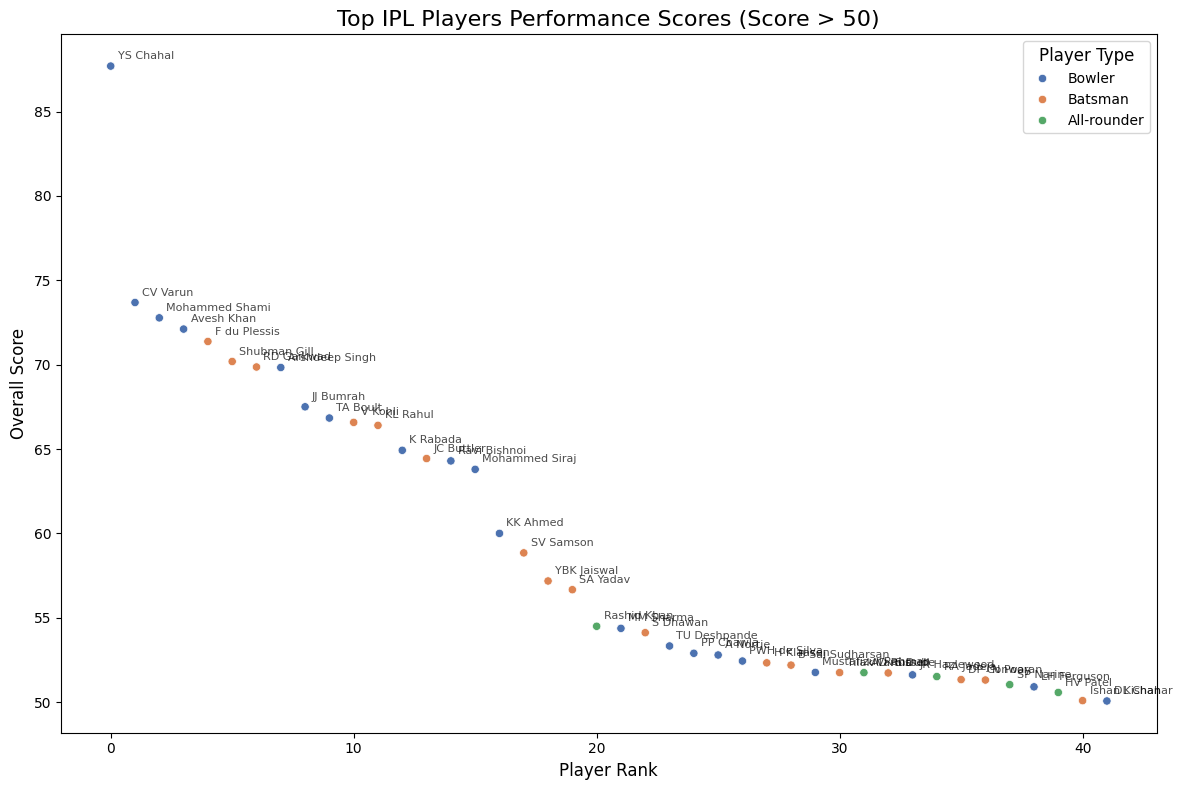

In [12]:
# Filter for players with Overall_score > 50
top_players = ranking_data[ranking_data['Overall_score'] > 50].sort_values('Overall_score', ascending=False)

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=top_players, x=range(len(top_players)), y='Overall_score', hue='Player_type', palette='deep')

# Customize the plot
plt.title('Top IPL Players Performance Scores (Score > 50)', fontsize=16)
plt.xlabel('Player Rank', fontsize=12)
plt.ylabel('Overall Score', fontsize=12)
plt.legend(title='Player Type', title_fontsize='12', fontsize='10')

# Annotate player names
for i, row in top_players.iterrows():
    plt.annotate(row['striker'], (top_players.index.get_loc(i), row['Overall_score']), 
                 xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

C:\Users\niran\AppData\Local\Temp\ipykernel_21964\3238966191.py:5: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.




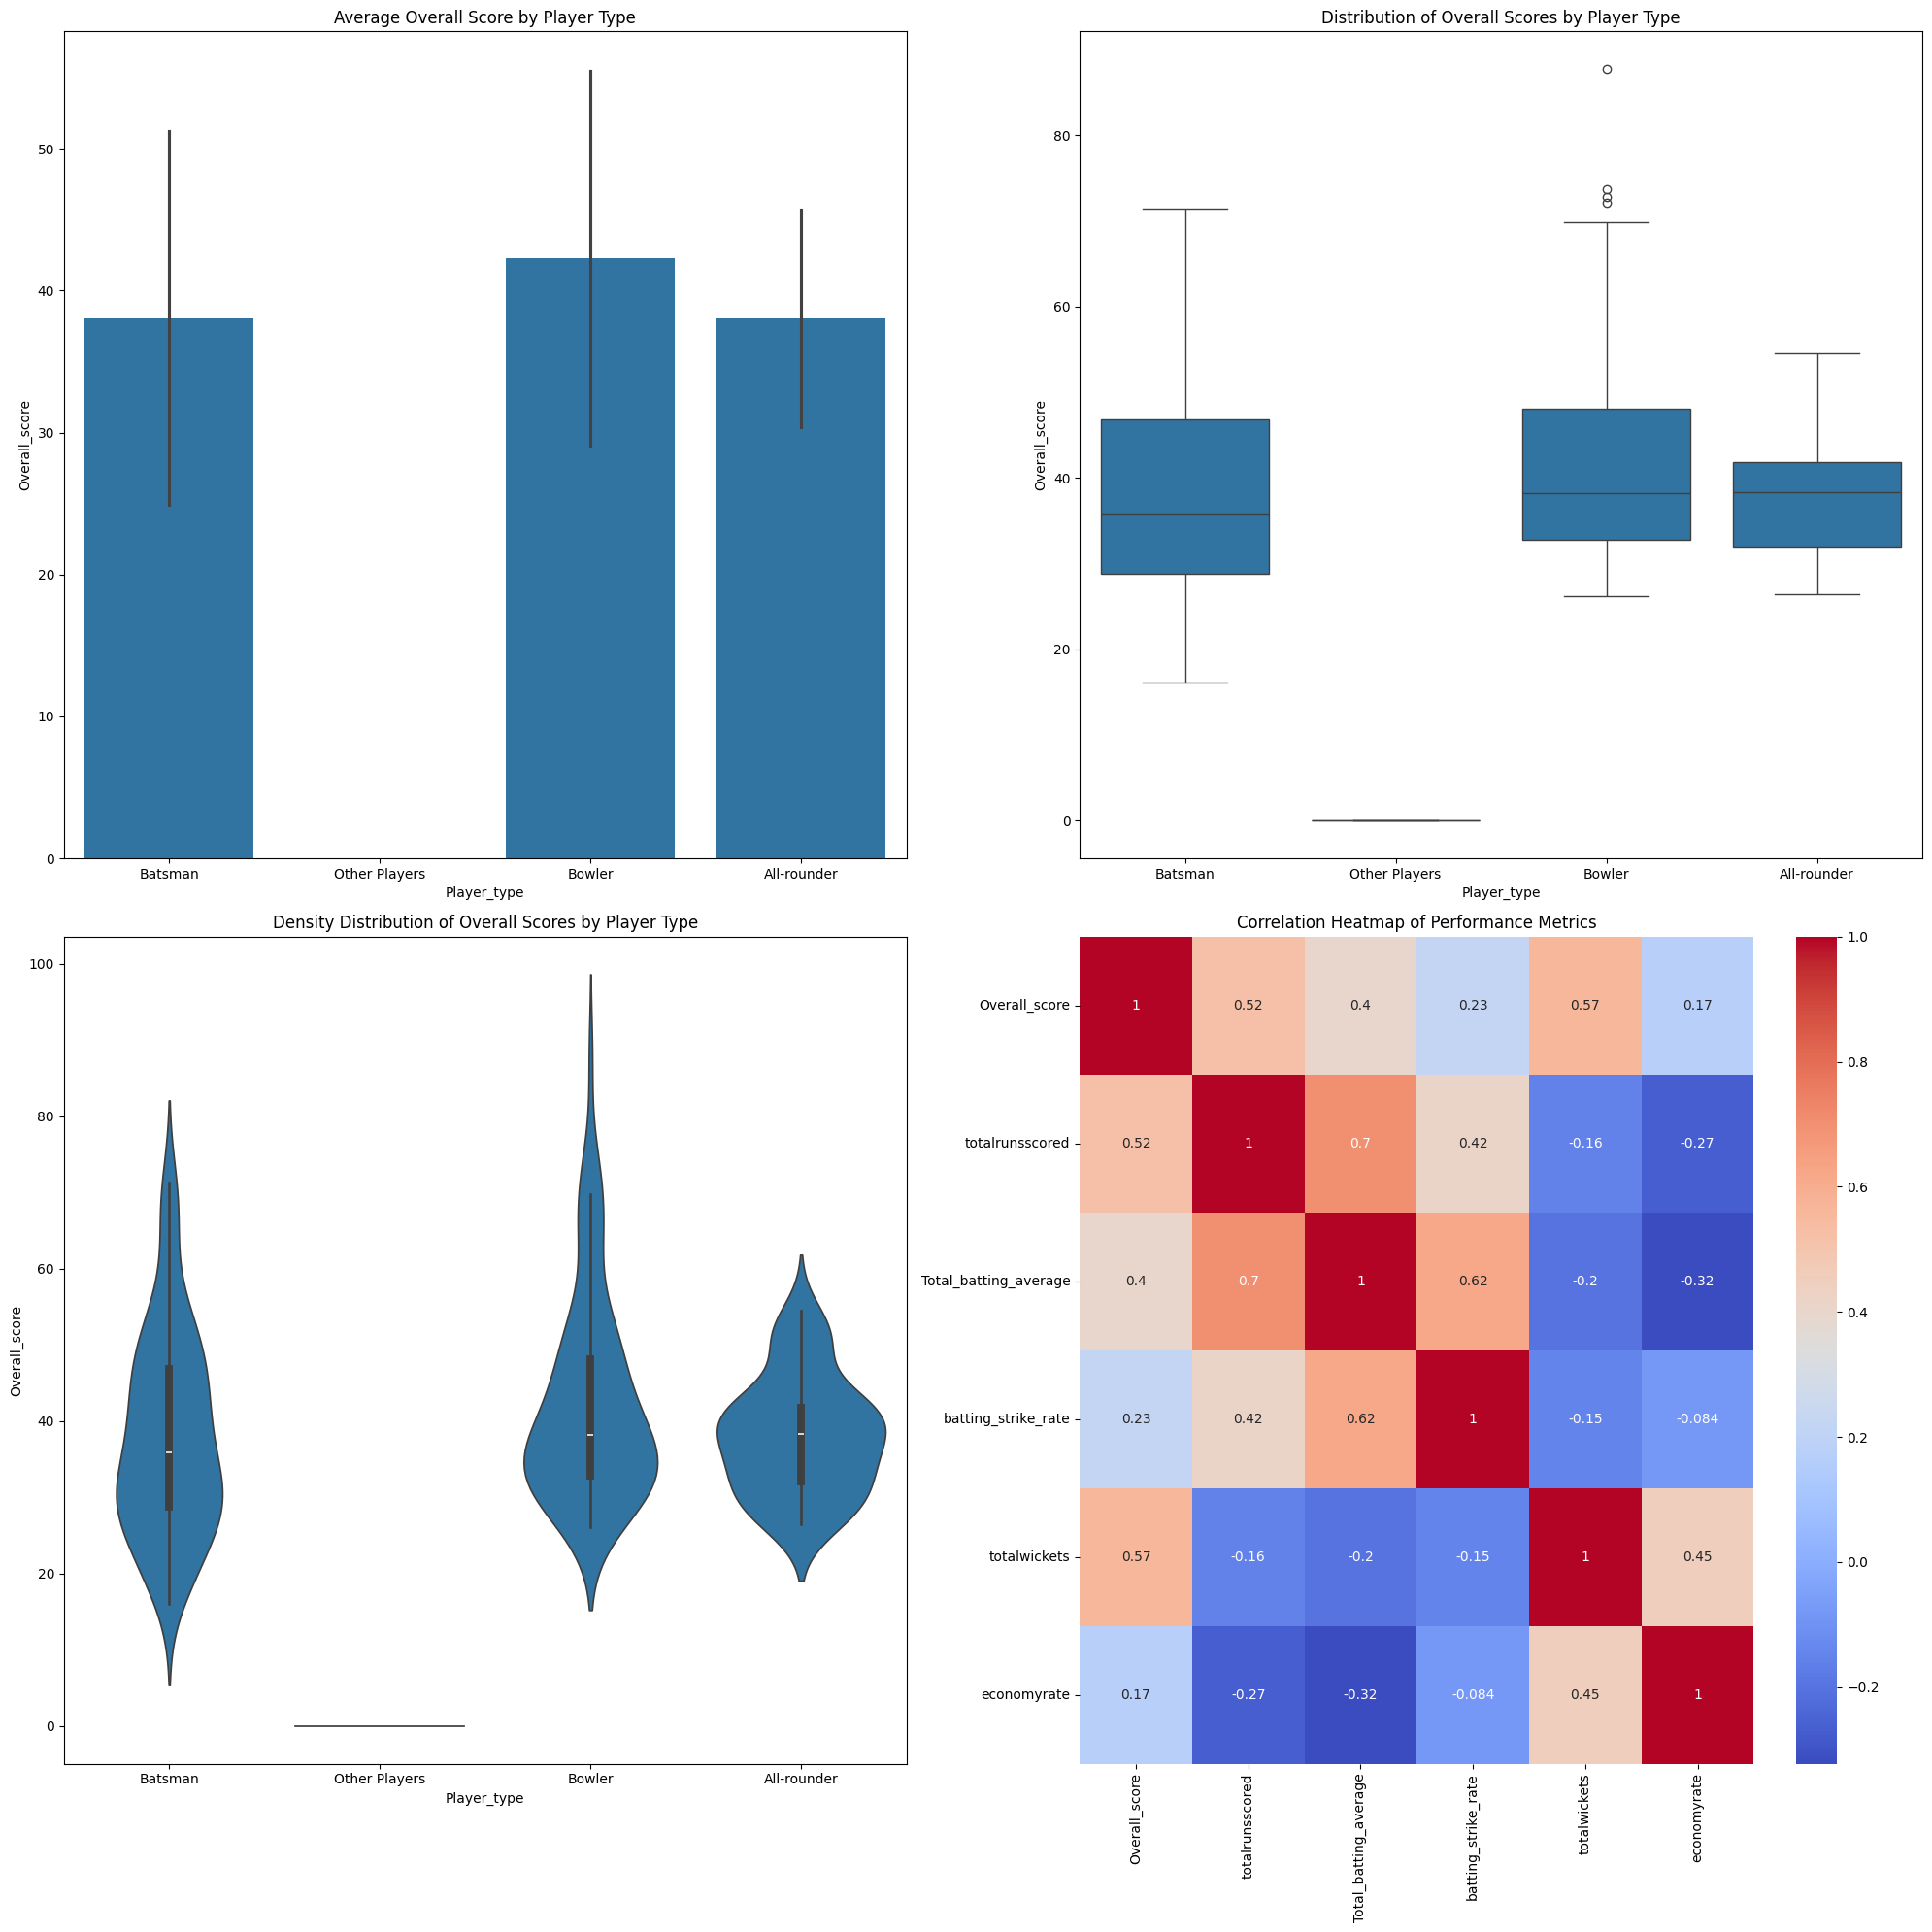

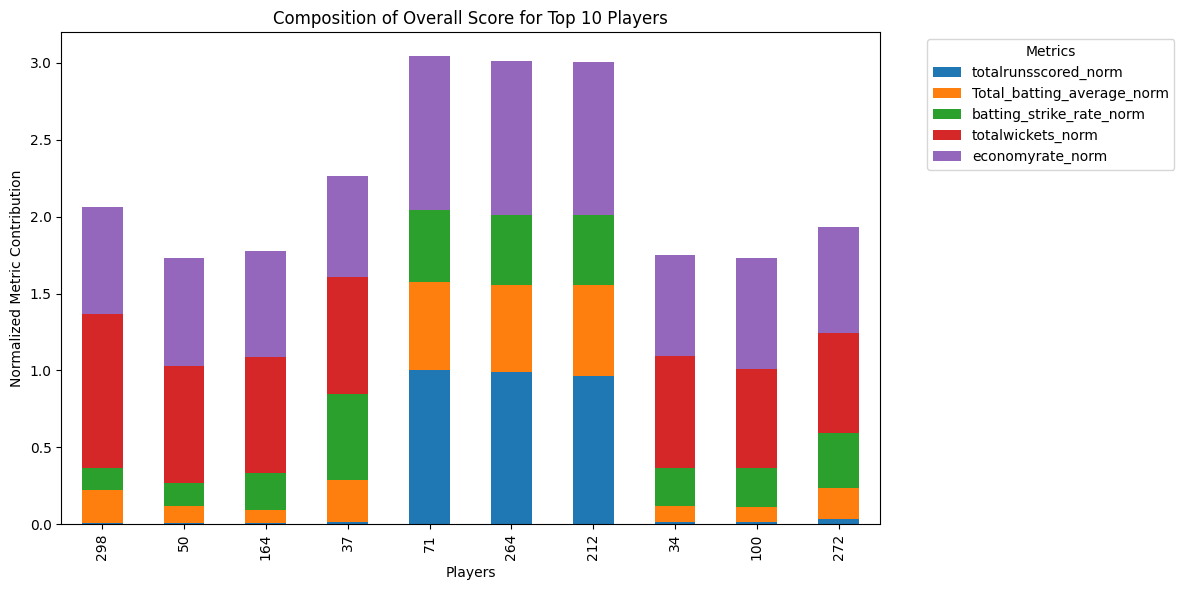

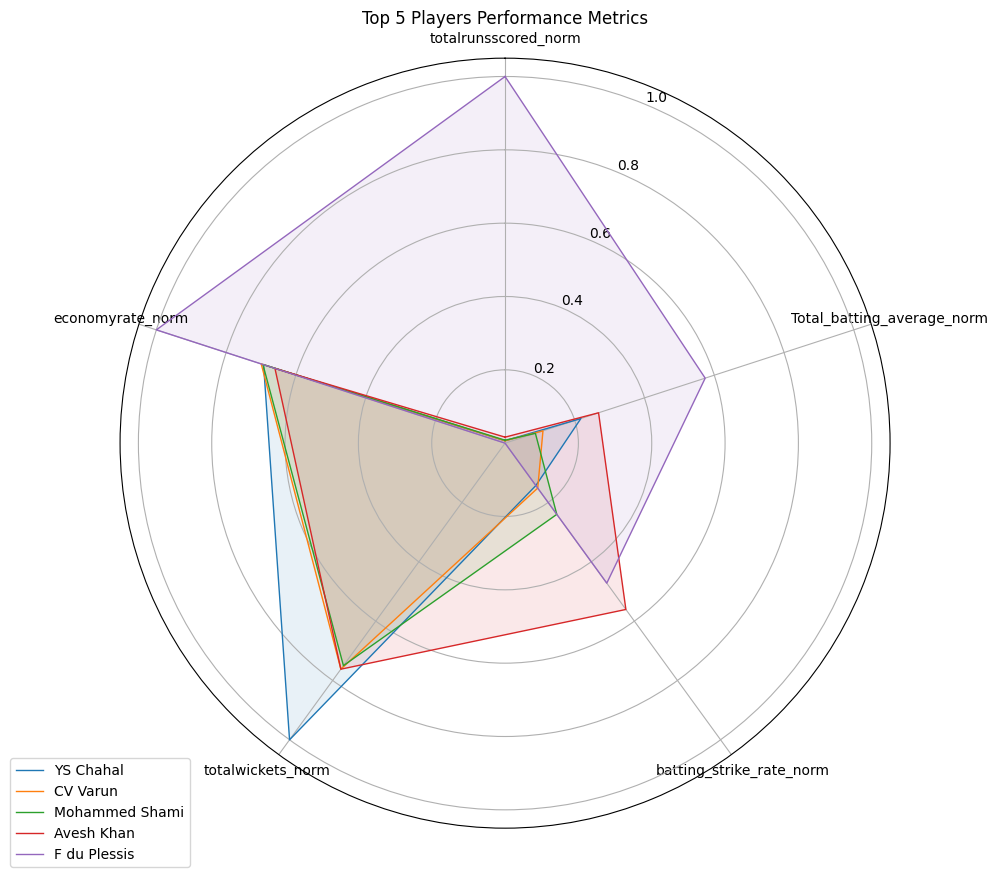

In [13]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

# 1. Bar Chart with Error Bars
sns.barplot(x='Player_type', y='Overall_score', data=ranking_data, ax=axes[0, 0], ci='sd')
axes[0, 0].set_title('Average Overall Score by Player Type')

# 2. Box Plot
sns.boxplot(x='Player_type', y='Overall_score', data=ranking_data, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Overall Scores by Player Type')

# 3. Violin Plot
sns.violinplot(x='Player_type', y='Overall_score', data=ranking_data, ax=axes[1, 0])
axes[1, 0].set_title('Density Distribution of Overall Scores by Player Type')

# 4. Heatmap
corr_metrics = ['Overall_score', 'totalrunsscored', 'Total_batting_average', 'batting_strike_rate', 'totalwickets', 'economyrate']
corr_matrix = ranking_data[corr_metrics].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axes[1, 1])
axes[1, 1].set_title('Correlation Heatmap of Performance Metrics')

plt.tight_layout()
plt.show()

# 5. Stacked Bar Chart for Top 10 Players
top_10 = ranking_data.nlargest(10, 'Overall_score')
metrics = ['totalrunsscored_norm', 'Total_batting_average_norm', 'batting_strike_rate_norm', 'totalwickets_norm', 'economyrate_norm']
top_10[metrics].plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Composition of Overall Score for Top 10 Players')
plt.xlabel('Players')
plt.ylabel('Normalized Metric Contribution')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 6. Radar Chart for Top 5 Players
top_5 = ranking_data.nlargest(5, 'Overall_score')
metrics = ['totalrunsscored_norm', 'Total_batting_average_norm', 'batting_strike_rate_norm', 'totalwickets_norm', 'economyrate_norm']

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
angles = [n / float(len(metrics)) * 2 * 3.141593 for n in range(len(metrics))]
angles += angles[:1]

for i, player in top_5.iterrows():
    values = player[metrics].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=player['striker'])
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(3.141593 / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
ax.set_title("Top 5 Players Performance Metrics")
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

Bar Chart: Average Overall Score by Player Type

C:\Users\niran\AppData\Local\Temp\ipykernel_21964\3818121586.py:8: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.


C:\Users\niran\AppData\Local\Temp\ipykernel_21964\3818121586.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




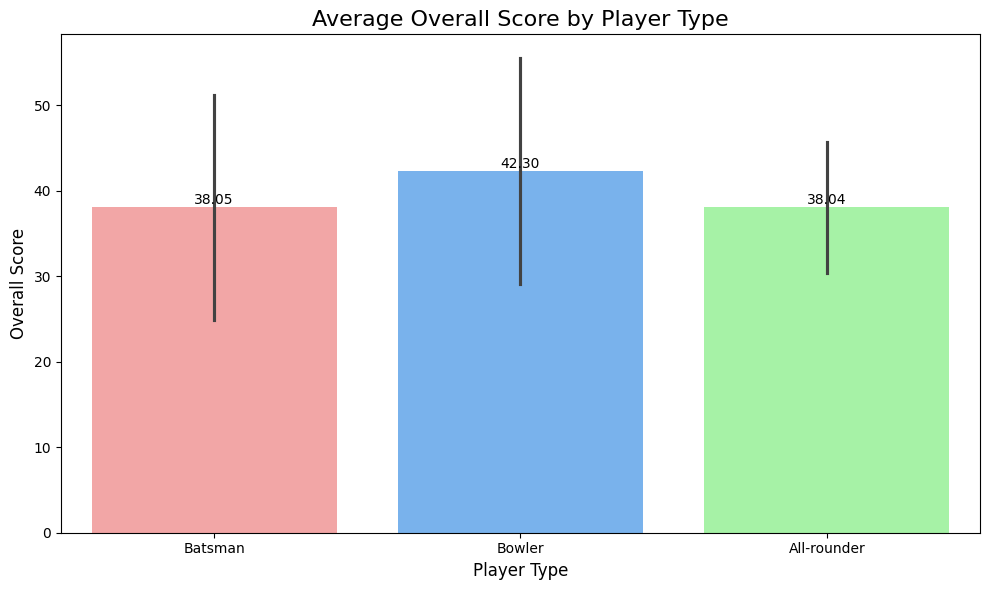

In [14]:

# Filter out 'Other' players
bar_df = ranking_data[ranking_data['Player_type'].isin(['Batsman', 'Bowler', 'All-rounder'])]

# Set a custom color palette
colors = {'Batsman': '#FF9999', 'Bowler': '#66B2FF', 'All-rounder': '#99FF99'}

plt.figure(figsize=(10, 6))
sns.barplot(x='Player_type', y='Overall_score', data=bar_df, ci='sd', palette=colors)

plt.title('Average Overall Score by Player Type', fontsize=16)
plt.xlabel('Player Type', fontsize=12)
plt.ylabel('Overall Score', fontsize=12)

# Add value labels on top of each bar
for i, player_type in enumerate(bar_df['Player_type'].unique()):
    avg_score = bar_df[bar_df['Player_type'] == player_type]['Overall_score'].mean()
    plt.text(i, avg_score, f'{avg_score:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

This bar chart displays the average overall score for Batsmen and Bowlers, excluding any players categorized as "Other Players." It provides a clear comparison of performance between these two key player types, highlighting which group tends to perform better on average.

Box Plot: Distribution of Overall Scores by Player Type

C:\Users\niran\AppData\Local\Temp\ipykernel_21964\175973844.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




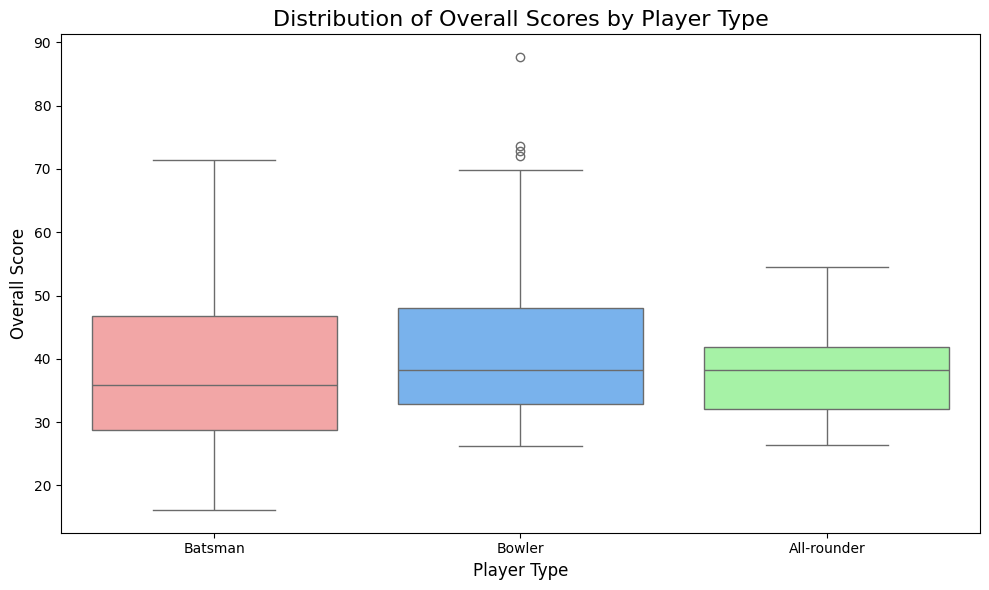

In [15]:
# Filter out 'Other' players
bar_df = ranking_data[ranking_data['Player_type'].isin(['Batsman', 'Bowler', 'All-rounder'])]

# Set a custom color palette
colors = {'Batsman': '#FF9999', 'Bowler': '#66B2FF', 'All-rounder': '#99FF99'}

plt.figure(figsize=(10, 6))
sns.boxplot(x='Player_type', y='Overall_score', data=bar_df, palette=colors)

plt.title('Distribution of Overall Scores by Player Type', fontsize=16)
plt.xlabel('Player Type', fontsize=12)
plt.ylabel('Overall Score', fontsize=12)

# # Add some jitter to the individual points
# sns.stripplot(x='Player_type', y='Overall_score', data=bar_df, color='black', alpha=0.5, jitter=0.3, size=4)

plt.tight_layout()
plt.show()

This box plot shows the distribution of overall scores for Batsmen and Bowlers. It highlights the median, quartiles, and any outliers within each category. This visualization is useful for understanding the spread of scores and identifying top performers in each group.

Scatter Plot: Overall Score vs. Total Runs Scored (for All rounder)

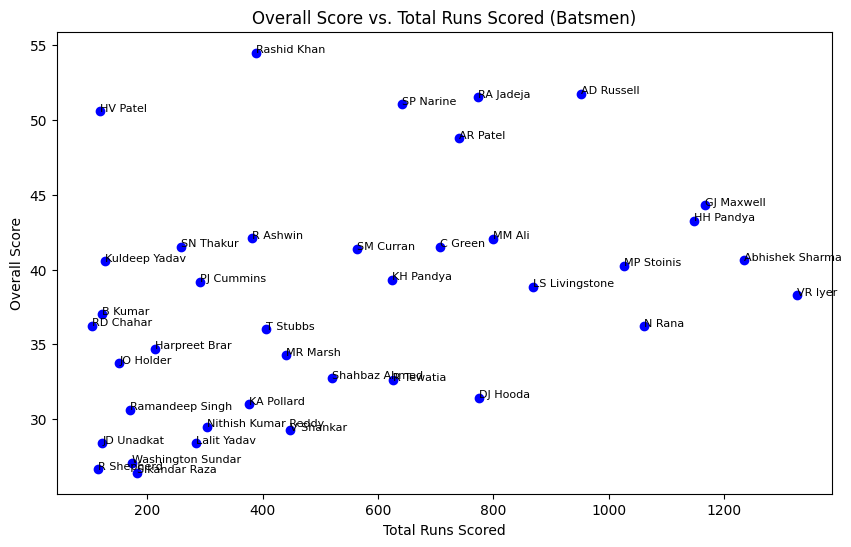

In [16]:
batsmen = ranked_data[ranked_data['Player_type'] == 'All-rounder']
plt.figure(figsize=(10, 6))
plt.scatter(batsmen['totalrunsscored'], batsmen['Overall_score'], color='blue')
plt.title('Overall Score vs. Total Runs Scored (Batsmen)')
plt.xlabel('Total Runs Scored')
plt.ylabel('Overall Score')
for i, txt in enumerate(batsmen['striker']):
    plt.annotate(txt, (batsmen['totalrunsscored'].iloc[i], batsmen['Overall_score'].iloc[i]), fontsize=8)
plt.show()

This scatter plot illustrates the relationship between total runs scored and overall score for Batsmen. Each point represents a batsman, and the player's name is annotated next to their respective point. This visualization helps identify how total runs correlate with overall scores among batsmen.

Top 10 Players by Overall Score (Excluding Other Players)

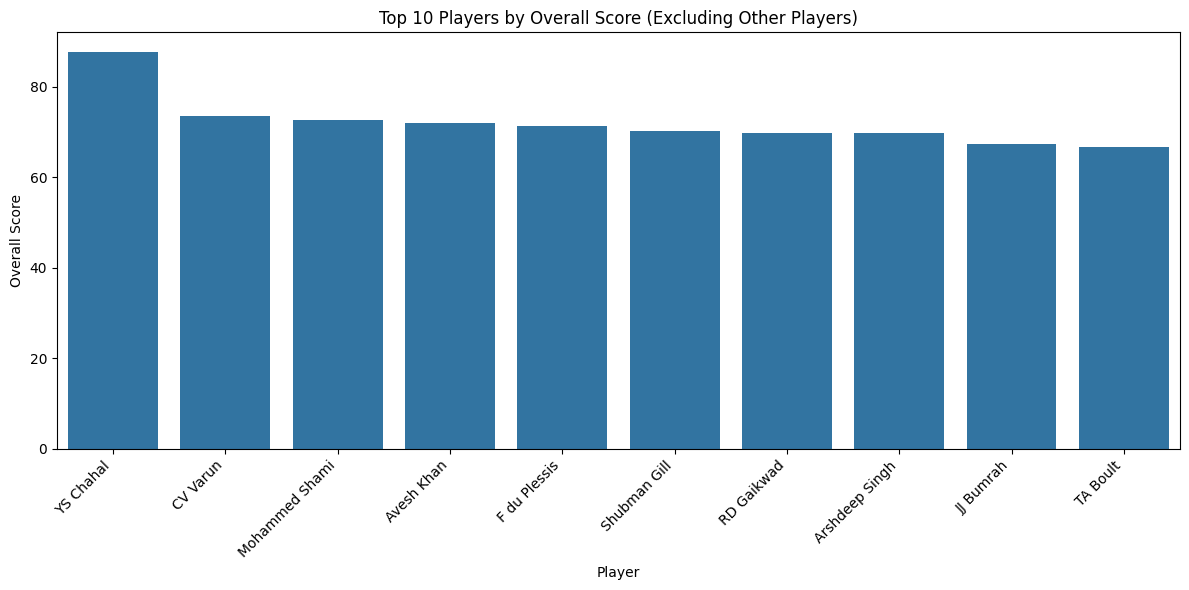

In [17]:
top_10 = ranking_data.nlargest(10, 'Overall_score')
plt.figure(figsize=(12, 6))
sns.barplot(x='striker', y='Overall_score', data=top_10)
plt.title('Top 10 Players by Overall Score (Excluding Other Players)')
plt.xlabel('Player')
plt.ylabel('Overall Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This bar chart shows the top 10 players by overall score, focusing only on Batsmen and Bowlers. It provides a clear ranking of the best performers, allowing for easy identification of standout players in the dataset.

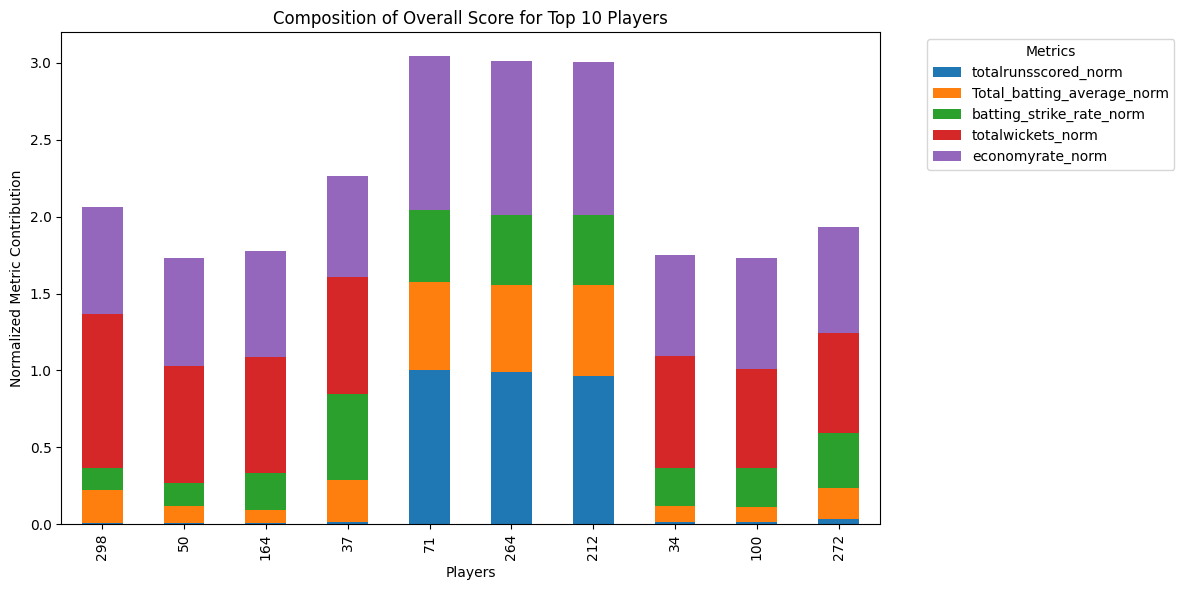

In [18]:

# 5. Stacked Bar Chart for Top 10 Players
top_10 = ranking_data.nlargest(10, 'Overall_score')
metrics = ['totalrunsscored_norm', 'Total_batting_average_norm', 'batting_strike_rate_norm', 'totalwickets_norm', 'economyrate_norm']
top_10[metrics].plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Composition of Overall Score for Top 10 Players')
plt.xlabel('Players')
plt.ylabel('Normalized Metric Contribution')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

This stacked bar chart visualizes the composition of the overall score for the top 10 players in the dataset. Each bar represents a player, and the segments within each bar show the normalized contributions of different performance metrics to their overall score. The metrics included are total runs scored, batting average, batting strike rate, total wickets, and economy rate.
The chart allows for easy comparison of how different players achieve their high overall scores. Some players may excel in run-scoring, while others might contribute more through wicket-taking or economic bowling. This visualization provides a comprehensive view of what makes these top players stand out, highlighting their strengths across various aspects of the game.

C:\Users\niran\AppData\Local\Temp\ipykernel_21964\2465764696.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




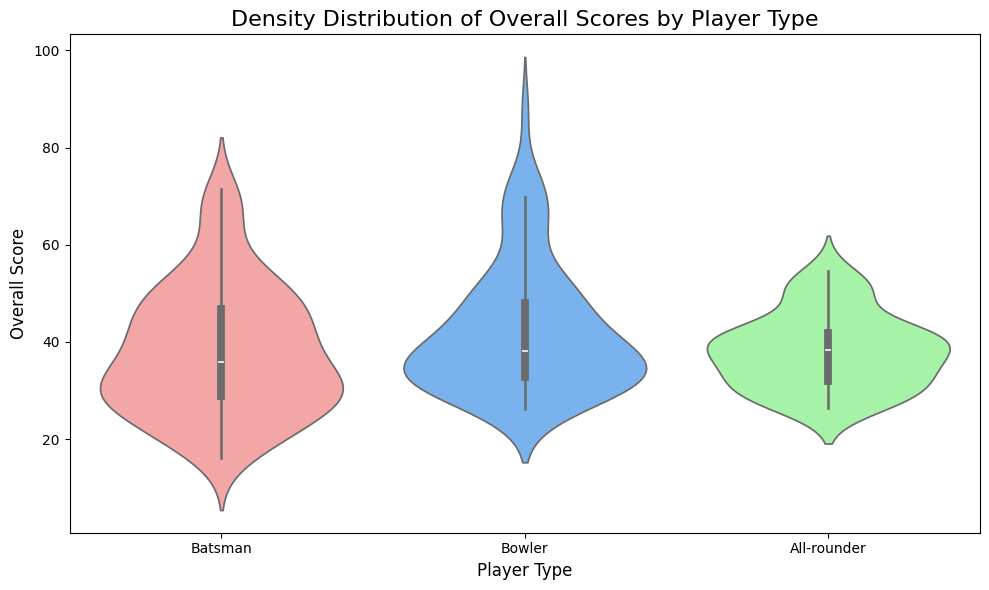

In [19]:
# Filter out 'Other' players
violin_df = ranking_data[ranking_data['Player_type'].isin(['Batsman', 'Bowler', 'All-rounder'])]

# Set a custom color palette
colors = {'Batsman': '#FF9999', 'Bowler': '#66B2FF', 'All-rounder': '#99FF99'}

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Player_type', y='Overall_score', data=violin_df, palette=colors)

plt.title('Density Distribution of Overall Scores by Player Type', fontsize=16)
plt.xlabel('Player Type', fontsize=12)
plt.ylabel('Overall Score', fontsize=12)



plt.tight_layout()
plt.show()

This violin plot will show the density distribution of overall scores for Batsmen, Bowlers, and All-rounders, allowing for easy comparison of score distributions across these player types. The width of each "violin" represents the density of data points at that score level, providing insight into the most common score ranges for each player type.

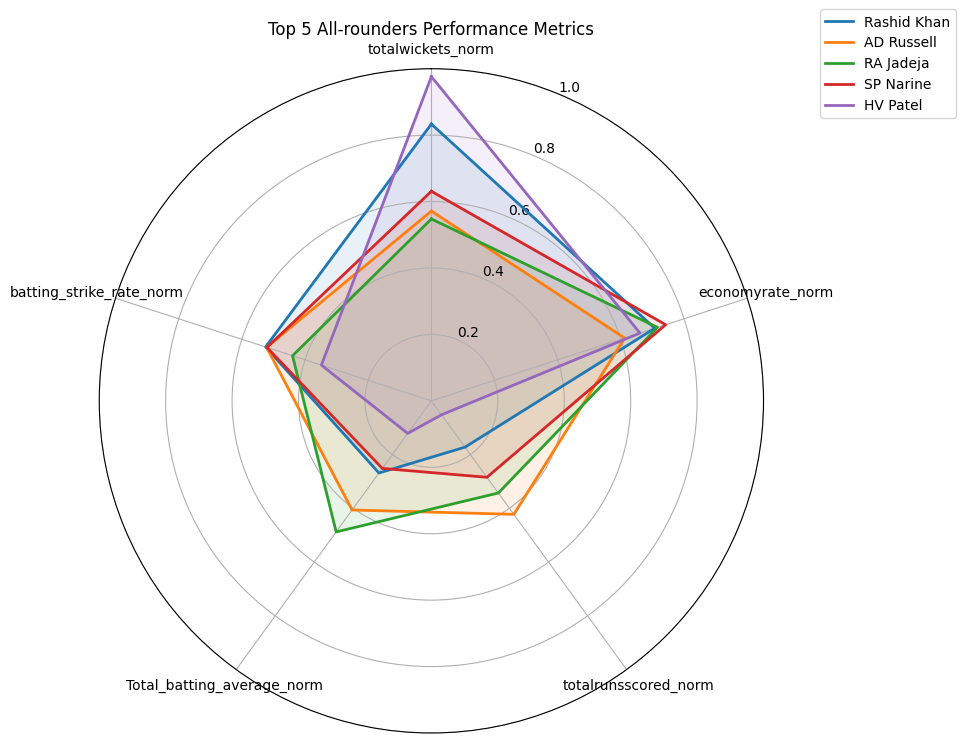

In [20]:
# Filter for all rounders and select top 5
top_5 = ranking_data[ranking_data['Player_type'] == 'All-rounder'].nlargest(5, 'Overall_score')

# Define metrics for all rounders
metrics = ['totalwickets_norm', 'economyrate_norm', 'totalrunsscored_norm', 'Total_batting_average_norm', 'batting_strike_rate_norm']

# Create the radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
angles = [n / float(len(metrics)) * 2 * np.pi for n in range(len(metrics))]
angles += angles[:1]

# Plot each bowler
for i, bowler in top_5.iterrows():
    values = bowler[metrics].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=bowler['striker'])
    ax.fill(angles, values, alpha=0.1)

# Customize the chart
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
ax.set_ylim(0, 1)
ax.set_title("Top 5 All-rounders Performance Metrics")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Show the plot
plt.tight_layout()
plt.show()

Each player is represented by a unique colored line connecting their scores across all metrics. The area enclosed by a player's line visually represents their overall performance - a larger area generally indicates better all-round performance.
This chart effectively highlights the strengths and weaknesses of each all-rounder. For example, a player might excel in wicket-taking (high totalwickets_norm) but have a lower economy rate (lower economyrate_norm). Similarly, it shows how players balance their bowling and batting performances.
The radar chart provides a quick, intuitive way to compare these top all-rounders and understand their performance profiles across multiple aspects of the game.

C:\Users\niran\AppData\Local\Temp\ipykernel_21964\3303130513.py:21: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



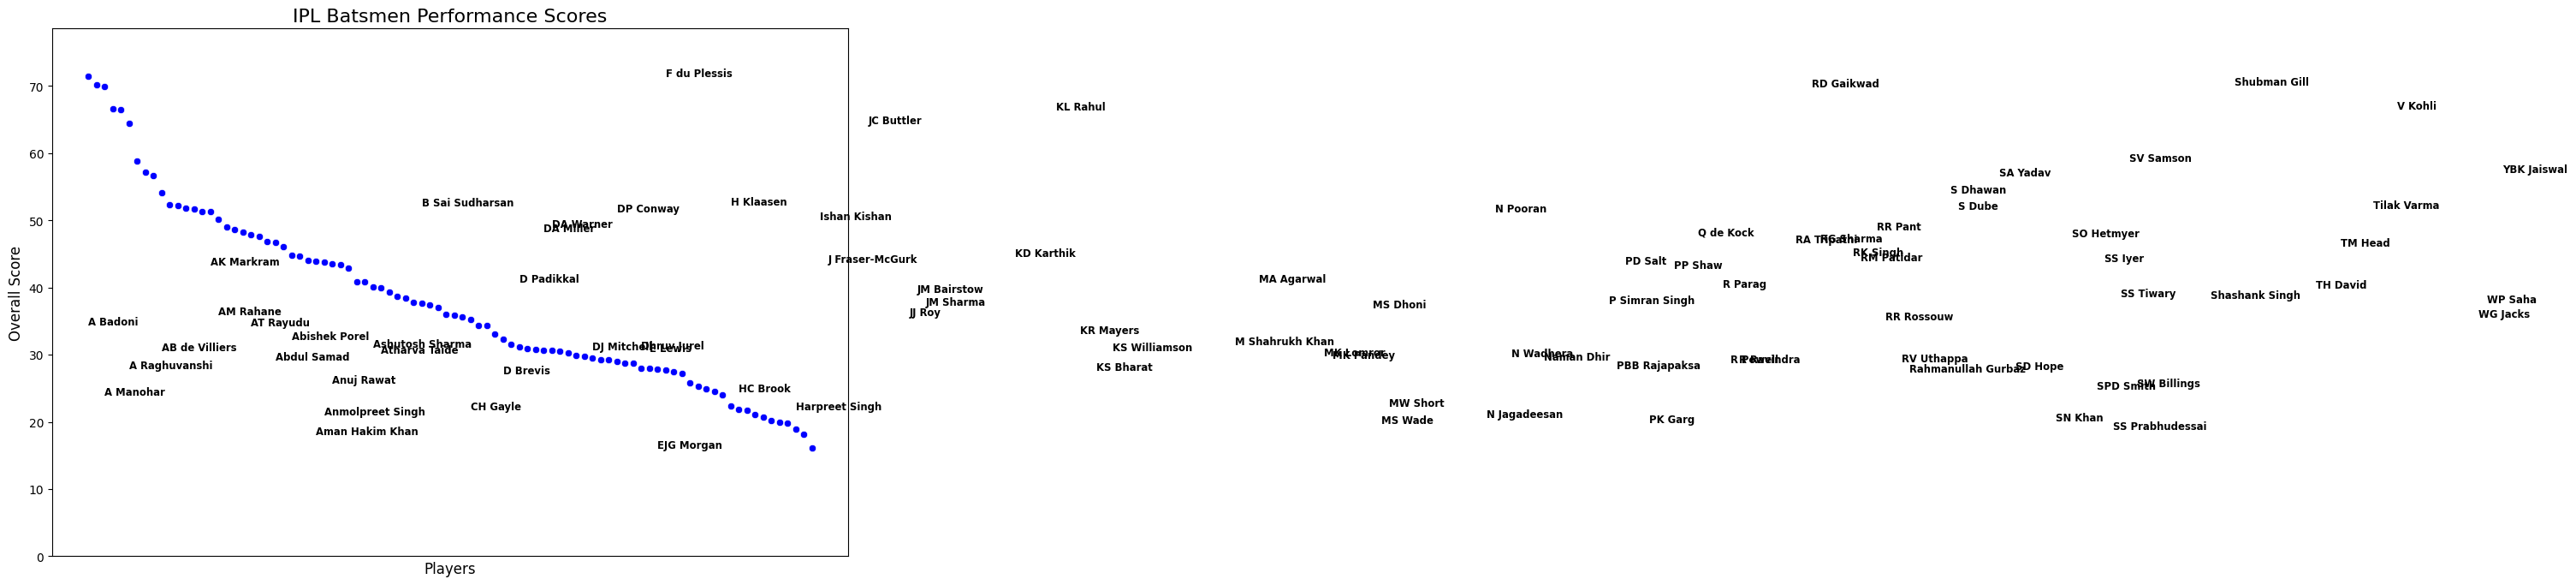

In [21]:
# Filter for batsmen only
batsmen = ranking_data[ranking_data['Player_type'] == 'Batsman'].sort_values('Overall_score', ascending=False)

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=batsmen, x='striker', y='Overall_score', color='blue')

# Annotate player names on the scatter plot
for i, row in batsmen.iterrows():
    scatter.text(row.name, row['Overall_score'], row['striker'], 
                 horizontalalignment='left', size='small', color='black', weight='semibold')

# Customize the plot
plt.title('IPL Batsmen Performance Scores', fontsize=16)
plt.xlabel('Players', fontsize=12)
plt.ylabel('Overall Score', fontsize=12)
plt.xticks([])  # Remove x-axis ticks as we're using annotations
plt.ylim(0, max(batsmen['Overall_score']) * 1.1)  # Set y-axis limit with some padding

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [22]:
ranking_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  302 non-null    int64  
 1   striker                     302 non-null    object 
 2   totalrunsscored             302 non-null    float64
 3   Total_batting_average       302 non-null    float64
 4   batting_strike_rate         302 non-null    float64
 5   totalballsfaced             302 non-null    float64
 6   totalwickets                302 non-null    float64
 7   economyrate                 302 non-null    float64
 8   oversbowled_clean           302 non-null    float64
 9   totalrunsscored_norm        302 non-null    float64
 10  Total_batting_average_norm  302 non-null    float64
 11  batting_strike_rate_norm    302 non-null    float64
 12  totalwickets_norm           302 non-null    float64
 13  economyrate_norm            302 non

Random forest model (regression) to predict the over all score

In [23]:
ranking_data.columns.to_list()

['Unnamed: 0',
 'striker',
 'totalrunsscored',
 'Total_batting_average',
 'batting_strike_rate',
 'totalballsfaced',
 'totalwickets',
 'economyrate',
 'oversbowled_clean',
 'totalrunsscored_norm',
 'Total_batting_average_norm',
 'batting_strike_rate_norm',
 'totalwickets_norm',
 'economyrate_norm',
 'Player_type',
 'Overall_score',
 'Rank']

                            totalrunsscored  Total_batting_average  \
totalrunsscored                    1.000000               0.703139   
Total_batting_average              0.703139               1.000000   
batting_strike_rate                0.416145               0.621497   
totalballsfaced                    0.994913               0.690230   
totalwickets                      -0.156821              -0.199768   
economyrate                       -0.266214              -0.322166   
oversbowled_clean                 -0.142819              -0.190167   
totalrunsscored_norm               1.000000               0.703139   
Total_batting_average_norm         0.703139               1.000000   
batting_strike_rate_norm           0.416145               0.621497   
totalwickets_norm                 -0.156821              -0.199768   
economyrate_norm                   0.266214               0.322166   
Overall_score                      0.520580               0.399196   
Rank                

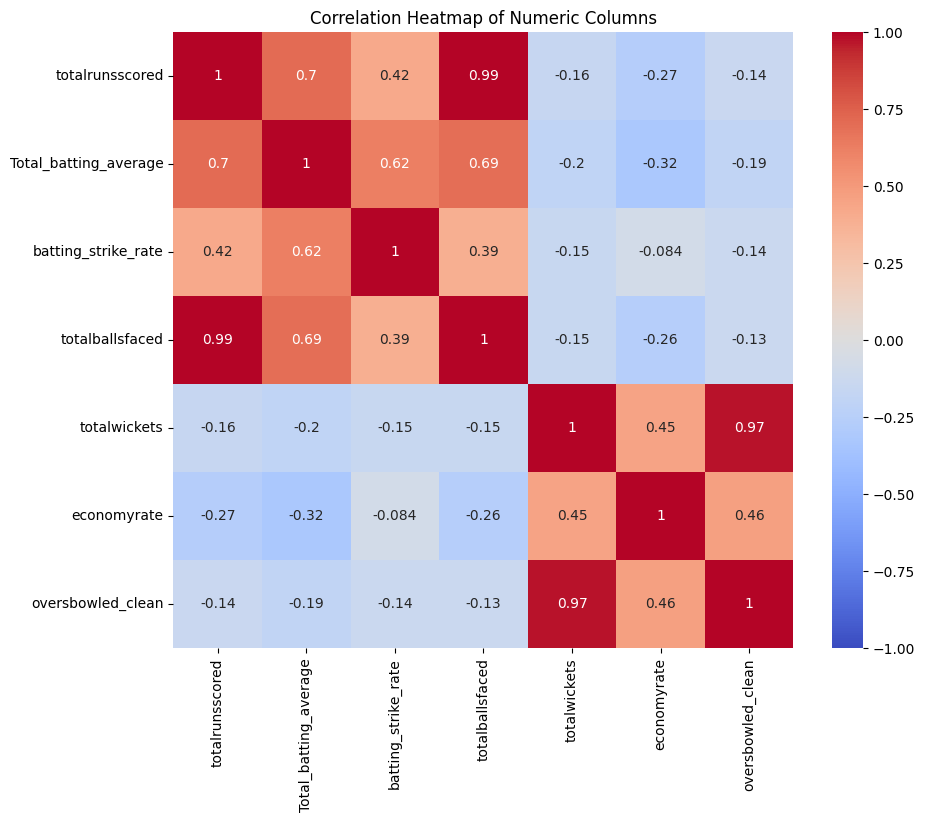

In [24]:
rf_data = ranking_data[['totalrunsscored',
 'Total_batting_average',
 'batting_strike_rate',
 'totalballsfaced',
 'totalwickets',
 'economyrate',
 'oversbowled_clean',
 'totalrunsscored_norm',
 'Total_batting_average_norm',
 'batting_strike_rate_norm',
 'totalwickets_norm',
 'economyrate_norm',
 'Overall_score',
 'Rank']]
rfm = rf_data.corr()

# Print correlation matrix
print(rfm)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cf, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

In [25]:
# Read data
model_data = pd.read_csv("Ranked_data.csv")

In [26]:
model_data.columns.to_list()

['Unnamed: 0',
 'striker',
 'totalrunsscored',
 'Total_batting_average',
 'batting_strike_rate',
 'totalballsfaced',
 'totalwickets',
 'economyrate',
 'oversbowled_clean',
 'totalrunsscored_norm',
 'Total_batting_average_norm',
 'batting_strike_rate_norm',
 'totalwickets_norm',
 'economyrate_norm',
 'Player_type',
 'Overall_score',
 'Rank']

In [27]:
# Prepare the features and target
X = model_data.drop(['Unnamed: 0', 'striker', 'Overall_score','Rank', 'totalrunsscored',
 'Total_batting_average',
 'batting_strike_rate',
 'totalballsfaced',
 'totalwickets',
 'economyrate',
 'oversbowled_clean'], axis=1)
y = model_data['Overall_score']
# Encode categorical variables
le = LabelEncoder()
X['Player_type'] = le.fit_transform(X['Player_type'])
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
# Accuracy of the model r2 * 100
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 2.6356552475871244
R-squared Score: 0.9942757011373764


In [28]:
model_data = ranking_data

In [29]:
# Prepare the features and target
X = model_data.drop(['Unnamed: 0', 'striker', 'Overall_score', 'totalrunsscored',
 'Total_batting_average',
 'batting_strike_rate',
 'totalballsfaced',
 'totalwickets',
 'economyrate',
 'oversbowled_clean','Rank'], axis=1)
y = model_data['Overall_score']

In [30]:
# Encode categorical variables
le = LabelEncoder()
X['Player_type'] = le.fit_transform(X['Player_type'])

In [31]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

In [33]:

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
# Accuracy of the model r2 * 100

In [34]:
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 4.626406225906842
R-squared Score: 0.9892666189587771


In [35]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                      feature  importance
5                 Player_type    0.756587
3           totalwickets_norm    0.131237
0        totalrunsscored_norm    0.085492
1  Total_batting_average_norm    0.018398
2    batting_strike_rate_norm    0.005891
4            economyrate_norm    0.002395


In [36]:
# Predict for next season
# Assume you have a dataframe 'next_season_data' with the same features as X
# next_season_predictions = rf_model.predict(next_season_data)
# print("Predictions for next season:", next_season_predictions)

In [37]:
# read data
data = pd.read_csv("Ranked_data.csv")

In [38]:
data.columns.to_list()

['Unnamed: 0',
 'striker',
 'totalrunsscored',
 'Total_batting_average',
 'batting_strike_rate',
 'totalballsfaced',
 'totalwickets',
 'economyrate',
 'oversbowled_clean',
 'totalrunsscored_norm',
 'Total_batting_average_norm',
 'batting_strike_rate_norm',
 'totalwickets_norm',
 'economyrate_norm',
 'Player_type',
 'Overall_score',
 'Rank']

In [39]:
new_data = pd.DataFrame({

 'totalrunsscored_norm': data['totalrunsscored_norm'],
    'Total_batting_average_norm': data['Total_batting_average_norm'],
    'batting_strike_rate_norm': data['batting_strike_rate_norm'],
    'totalwickets_norm': data['totalwickets_norm'],
    'economyrate_norm': data['economyrate_norm'],
    'Player_type': data['Player_type'] 
   
})

# Encode the 'Player_type' for the new data
new_data['Player_type'] = le.transform(new_data['Player_type'])

# Make predictions for the new input data
predicted_score = rf_model.predict(new_data)


# Add predictions to the example data
new_data['Predicted_Overall_score'] = predicted_score

# Add player names to the example data
new_data['Player'] = data['striker']

# Display results
print(new_data[['Player','Predicted_Overall_score']])

             Player  Predicted_Overall_score
0         YS Chahal                79.871083
1          CV Varun                74.478346
2    Mohammed Shami                72.634027
3        Avesh Khan                70.943222
4      F du Plessis                70.017928
..              ...                      ...
297     Virat Singh                 0.000000
298    Vishnu Vinod                 0.000000
299  Vivrant Sharma                 0.000000
300        YV Dhull                 0.000000
301   Yudhvir Singh                 0.000000

[302 rows x 2 columns]


In [44]:
# new_data.to_csv("random_forest_model_1_prediction.csv")

Visualizing the model

Actual vs Predicted Values Scatter Plot: This plot shows how well the predicted values align with the actual values. Points closer to the red dashed line indicate better predictions.

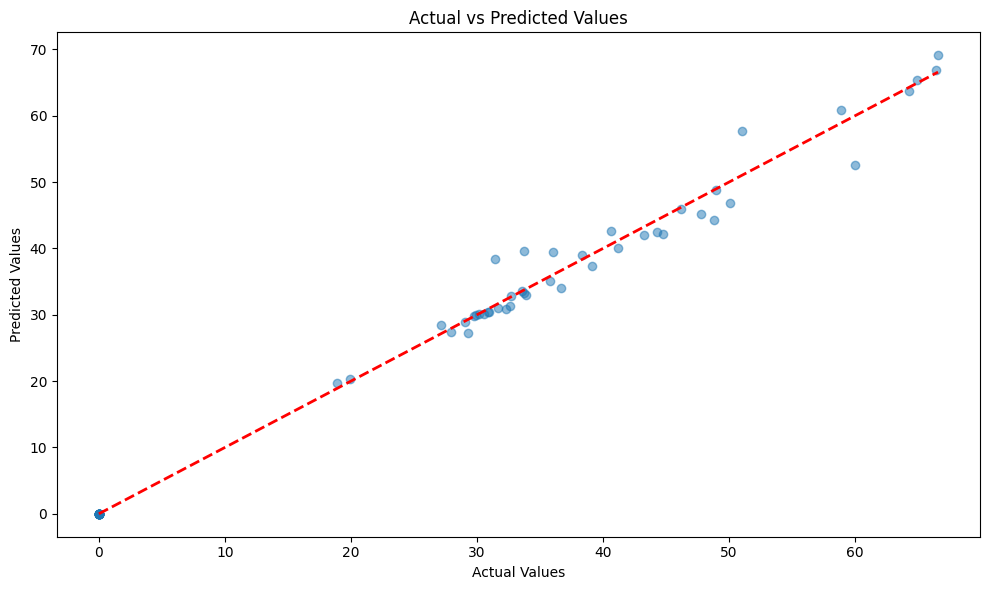

In [41]:
# 1. Actual vs Predicted values scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.show()

Residuals Plot: This plot helps identify any patterns in the residuals (prediction errors). Ideally, the residuals should be randomly scattered around the horizontal line at y=0.

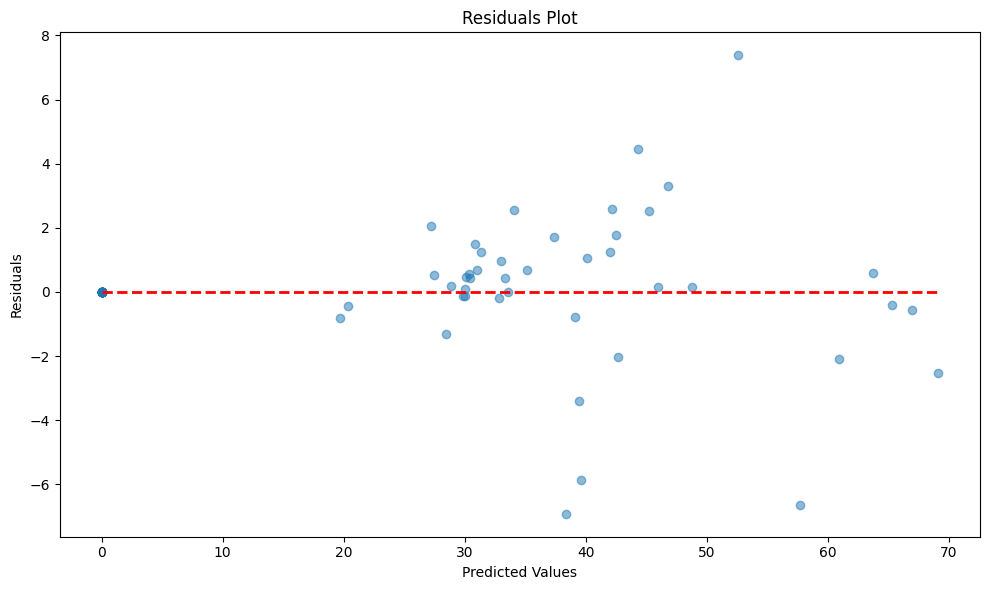

In [42]:
# 2. Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.plot([y_pred.min(), y_pred.max()], [0, 0], 'r--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.tight_layout()
plt.show()

Prediction Error Distribution Histogram: This histogram shows the distribution of prediction errors. A distribution centered around zero and symmetric indicates good model performance.

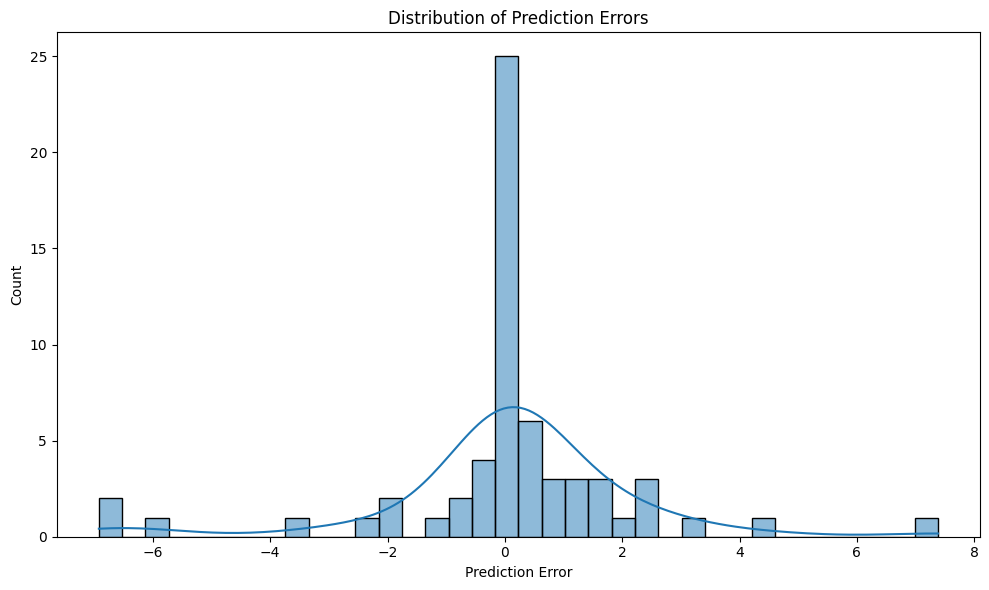

In [43]:
# 4. Prediction error distribution histogram
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Distribution of Prediction Errors')
plt.tight_layout()
plt.show()

